In [25]:
import numpy as np
import torch
import chess
import matplotlib.pyplot as plt

In [3]:
# convert a position to the tensor representation used by the nn
def board_2_tensor(board: chess.Board) -> torch.tensor:
    nums = np.empty(13, dtype=np.uint64)
    for i in range(6):
        nums[i] = int(board.pieces(i + 1, chess.WHITE))
        nums[i + 6] = int(board.pieces(i + 1, chess.BLACK))

    nums[12] = 1 << board.ep_square if board.has_legal_en_passant() else 0

    bits = np.unpackbits(nums.view(np.uint8))
    return torch.tensor(bits).float()

def moves_2_str(moves):
    s = ""
    for m in moves:
        s += str(m) + " "
    return s + "\n"

In [302]:
import torch
import torch.nn as nn


class NN(torch.nn.Module):

    def __init__(self, inputs: int):
        super().__init__()

        self.l1 = nn.Linear(inputs, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return x

In [234]:
# count and weight the material for each side, a very simple evaluation metric
def static_material_eval(board: chess.Board) -> float:
    # 1 - pawn, 3 - knight, bishop, 5 - rook, 9 - queen, 50 - king
    type_value = [1, 3, 3, 5, 9, 50]
    
    score = 0
    for i in range(6):
        score += bin(int(board.pieces(i + 1, chess.WHITE))).count("1") * type_value[i] # count the number of 1s and weight with the piece value
        score -= bin(int(board.pieces(i + 1, chess.BLACK))).count("1") * type_value[i]
    return score

# return the score of the position - black, + white and if the game is over
def eval_position(board: chess.Board, model: nn) -> (float, bool):
    
    if board.is_game_over():
        if board.is_checkmate():
            # if white is checkmate black gets an -infinit score and inf for black in checkmate
            return (float("-inf"), True) if board.turn else (float("inf"), True)
        # 0 score for a draw
        return 0, True

    # if the game is not over evaluate the board using the nn
    return model.forward(board_2_tensor(board)), False
    # return static_material_eval(board), False

In [6]:
# a minmax tree search of each possible move util the max depth is reached using alpha beta pruning
def minmax(board: chess.Board, model: NN, depth: int, alpha: float, beta: float, is_maximizing: bool) -> (float, list):
    
    score, is_gameover = eval_position(board, model)
    if is_gameover or depth is 0:
        # stop the tree search and return, no move is returned because there are no legals or we stop exploring here
        return score, []

    best_moves = []
    best_score = 0
    # white wants to maximize the score
    if is_maximizing:
        best_score = float("-inf")

        for move in board.generate_legal_moves():
            board.push(move)
            score, next_moves = minmax(board, model, depth - 1, alpha, beta, False)
            board.pop()

            if score >= best_score:
                best_score = score
                best_moves = [move] + next_moves
            alpha = max(alpha, score)

            if alpha >= beta:
                break

    # black wants to minimize the score
    else:
        best_score = float("inf")
        
        for move in board.generate_legal_moves():
            board.push(move)
            score, next_moves = minmax(board, model, depth - 1, alpha, beta, True)
            board.pop()

            if score <= best_score:
                best_score = score
                best_moves = [move] + next_moves
            beta = min(beta, score)

            if beta <= alpha:
                break

    return best_score, best_moves

# search each depth and return early if there is a checkmate
def find_best_move(board, model, depth):
    move = None
    for i in range(depth + 1):
        score, move = minmax(board, model, i, float("-inf"), float("inf"), board.turn)
        if score in [float("-inf"), float("inf")]:
            break
    return score, move

In [220]:
# stop exploring if the time unit for this branch fall below this threshold
TIME_TRSH = 1

# a tree search like minmax, but no alpha beta pruning. instead we eval each possition and allocate units of time depending on the score
def dynamic_move_search(board, model, time, is_maximizing) -> (float, chess.Move):

    # first, eval all next moves. this is used to allocate the time proportional later
    moves = list(board.generate_legal_moves())
    scores = np.empty(len(moves))
    gameovers = np.empty(len(moves), dtype=np.bool)

    for i, move in enumerate(moves):
            board.push(move)
            scores[i], gameovers[i] = eval_position(board, model)

            # if there is a checkmate for the opposide side, it will choose it and stop exploring
            if board.is_checkmate() and board.turn is not is_maximizing:
                board.pop()
                return scores[i], move

            board.pop()

    # if ther is no more time for this branch...
    if time < TIME_TRSH:
        # ...find the best move for the plaing side
        if is_maximizing:
            return np.max(scores), moves[np.argmax(scores)]
        else:
            return np.min(scores), moves[np.argmin(scores)]

    # if there still is time, allocate it proportional to the score and keep exploring
    if is_maximizing:
        scaled_scores = np.nan_to_num(scores) - np.min(scores) + 0.1
    else:
        scaled_scores = np.nan_to_num(-scores) - np.min(-scores) + 0.1
    time_factors = scaled_scores / np.sum(scaled_scores)


    if is_maximizing:
        best_score = float("-inf")

        for move, is_gameover, time_factor in zip(moves, gameovers, time_factors):
            if is_gameover:
                continue
            board.push(move)
            scores[i], _ = dynamic_move_search(board, model, time * time_factor, False)
            board.pop()

        # print("\t" * calls, scores, gameovers)
        return np.max(scores), moves[np.argmax(scores)]

    else:
        best_score = float("inf")

        for move, is_gameover, time_factor in zip(moves, gameovers, time_factors):
            if is_gameover:
                continue
            board.push(move)
            scores[i], _ = dynamic_move_search(board, model, time * time_factor, True)
            board.pop()

        # print("\t" * calls, scores, gameovers)
        return np.min(scores), moves[np.argmin(scores)]

In [230]:
# plays a game against itself, return all positions form the game and the final score
def play_game(time: int, model: NN):
    b = chess.Board()
    positions = np.empty([0, 832])

    game_over = False
    i = 0
    while not game_over:
        positions = np.append(positions, board_2_tensor(b))

        score, move = dynamic_move_search(b, model, time, b.turn)
        b.push(move)
        game_over = b.is_game_over()
        i += 1

    result, _ = eval_position(b, model)
    
    return positions, result, b

132 0


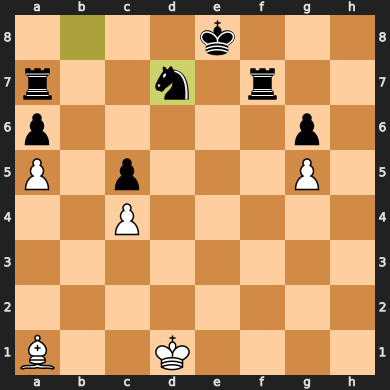

In [240]:
model = NN(64 * 13)
p, r, b = play_game(5, model)
print(b.ply(), r)
b

In [241]:
def train(model, iters):
    pass

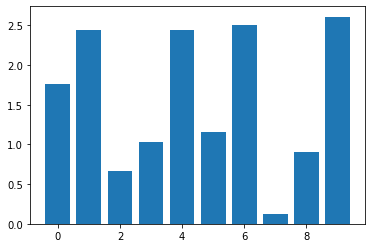

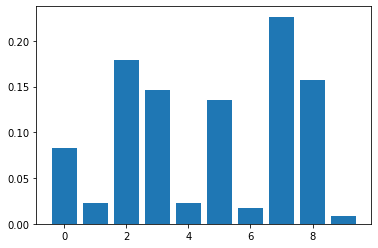

9

In [242]:
arr = np.random.rand(10) * 3

s_arr = np.nan_to_num(-arr) - np.min(-arr) + 0.1
time_factor = s_arr / np.sum(s_arr)

plt.bar(np.arange(arr.size), arr)
plt.show()
plt.bar(np.arange(arr.size), time_factor)
plt.show()

np.argmax(arr)

In [294]:
with open("../results", "r") as f:
    res = f.read()

ls = res.split("\n")
rms = []
for i, l in enumerate(ls):
    t = list(filter(lambda x: x != '', l.split(" ")))
    try:
        t[:5] = [float(x) for x in t[:5]]
    except ValueError:
        rms.append(i)
        continue
    ls[i] = t

r = rms.sort(reverse=True)
for r in rms:
    ls.pop(r)

ls = list(filter(lambda x: len(x) != 0, ls))
ls.sort(key=lambda x: x[3], reverse=True)
for l in ls:
    for e in l:
        print(f"{e:>10}", end="\t")
    print()

       1.0	       0.0	       0.0	    20.531	    20.531	main.py:1(<module>)	
       1.0	       0.0	       0.0	    18.642	    18.642	main.py:88(play_game)	
   50016.0	     0.212	       0.0	     15.82	       0.0	main.py:11(eval_position)	
   50015.0	     0.412	       0.0	    10.624	       0.0	neuralnet.py:15(forward)	
  200060.0	     0.764	       0.0	    10.036	       0.0	module.py:715(_call_impl)	
  200060.0	     0.286	       0.0	     8.983	       0.0	linear.py:92(forward)	
  200060.0	     2.552	       0.0	     8.618	       0.0	functional.py:1669(linear)	
  200060.0	     4.182	       0.0	     4.182	       0.0	   {method	  'matmul'	        of	'torch._C._TensorBase'	  objects}	
   50068.0	     0.589	       0.0	     2.715	       0.0	util.py:42(board_2_tensor)	
   50023.0	     2.228	       0.0	     2.233	       0.0	   {method	    'cuda'	        of	'torch._C._TensorBase'	  objects}	
       1.0	       0.0	       0.0	     1.317	     1.317	module.py:449(cuda)	
       8.0	       0.0	       0.0	  

In [296]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
a = torch.zeros(4,3)    
a = a.to(device)

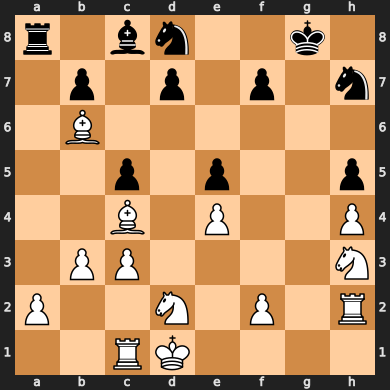

In [299]:
b = chess.Board("r1bn2k1/1p1p1p1n/1B6/2p1p2p/2B1P2P/1PP4N/P2N1P1R/2RK4 b - - 17 27")
b

In [305]:
import pickle
net = NN(64 * 13)
with open("../models/model", "wb") as f:
    pickle.dump(net, f)